## Problem 2
___

For this part of the assignment we will train a convolutional network on MNIST using Pytorch.

### Summary: 
___

[Question 1](#2.1)  
[Question 2](#2.2)

___

### 1. Come up with a CNN architecture with more or less similar number of parameters as MLP trained in Problem 1 and describe it. <a id='2.1'></a>
___

We implement a convolutional neural network with 4 convolutional layers, 4 pooling layers and one last fully connected layer. 

Here are the characteristics of these layers:

- convolutional layer $1$: $32$ kernel, kernel size is $3 * 3$ with a padding equal to $1$. Number of learnable parameters: $(9+1) * 16 = 160$.  

- pooling layer 1: kernel size is $2 * 2$ with a stride equal to $2$. Number of learnable parameters: $0$.  

- convolutional layer $2$: $64$ kernel, kernel size is $3 * 3$ with a padding equal to $1$. Number of learnable parameters: $(9+1) * 32 = 320$.  

- pooling layer 2: kernel size is $2 * 2$ with a stride equal to $2$. Number of learnable parameters: $0$.  

- convolutional layer $3$: $128$ kernel, kernel size is $3 * 3$ with a padding equal to $1$. Number of learnable parameters: $(9+1) * 64 = 640$.  

- pooling layer $3$: kernel size is $2 * 2$ with a stride equal to $2$. Number of learnable parameters: $0$.  

- convolutional layer $4$: $512$ kernel, kernel size is $3 * 3$ with a padding equal to $1$. Number of learnable parameters: $(9+1) * 128 = 1280$.  

- pooling layer $4$: kernel size is $2 * 2$ with a stride equal to $2$. Number of learnable parameters: $0$.  

- last fully connected layer: number of learnable parameters: $(128*9+1) * 10 =  11530$.  
            
The total number of learnable parameters is: $10 * 32 + (9*32 + 1) * 64 + (9*64+1) * 128 + (9*128+1) *512 = 688138$.

We compare this model to the best model of the first part. This latter has $2$ hidden layers of $500$ units each. Thus, it has $(784+1) * 500 +(500+1) * 500+(500+1) * 10 = 648010$. We notice then that the two networks have close number of parameters.


Here is the implementation of our convolutional network:

In [0]:
import numpy as np
from IPython.display import clear_output
import copy
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch import utils
from torch.utils.data import DataLoader, Dataset


import torchvision
import torchvision.transforms

import pickle


# loading the data 
u = pickle._Unpickler(open('./data/mnist.pkl', 'rb'))
u.encoding = 'latin1'
train_set, valid_set, test_set = u.load()

# class to customize the dataset 

class CustomDataset(Dataset):
    
    def __init__(self, X, y=None, transform=None, imreshape = False):
        self.X = X
        self.y = y
        self.transform = transform
        self.imreshape = imreshape
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X[index,:].copy()
        if self.y is not None:
            label = self.y[index].copy()
        if self.imreshape:
            image = image.reshape(28,28,1)
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [0]:
from torchvision import transforms, datasets

# transforming the data

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
    ])

# here are the 3 splits of the data into train, validation and test sets

mnist_train = CustomDataset(train_set[0],y=train_set[1], transform=data_transform, imreshape=True)
mnist_valid = CustomDataset(valid_set[0],y=valid_set[1], transform=data_transform, imreshape=True)
mnist_test = CustomDataset(test_set[0],y=test_set[1], transform=data_transform, imreshape=True)

In [163]:
# here is the shape of a given image
mnist_train.__getitem__(0)[0].shape

torch.Size([1, 28, 28])

In [0]:
# getting the loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=100, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=True, num_workers=2)

labels tensor([5, 9, 2, 2, 5, 7, 7, 7, 8, 2, 9, 8, 6, 9, 1, 7, 9, 5, 7, 5, 4, 9, 4, 9,
        5, 8, 4, 9, 5, 2, 8, 1, 2, 2, 7, 2, 0, 8, 9, 5, 0, 9, 0, 0, 9, 2, 2, 9,
        4, 1, 0, 4, 1, 9, 5, 7, 5, 5, 2, 5, 1, 8, 1, 6, 3, 6, 2, 2, 3, 1, 1, 4,
        7, 2, 9, 0, 8, 9, 2, 2, 3, 0, 0, 6, 3, 2, 9, 0, 4, 5, 2, 6, 7, 1, 0, 6,
        7, 8, 0, 4])


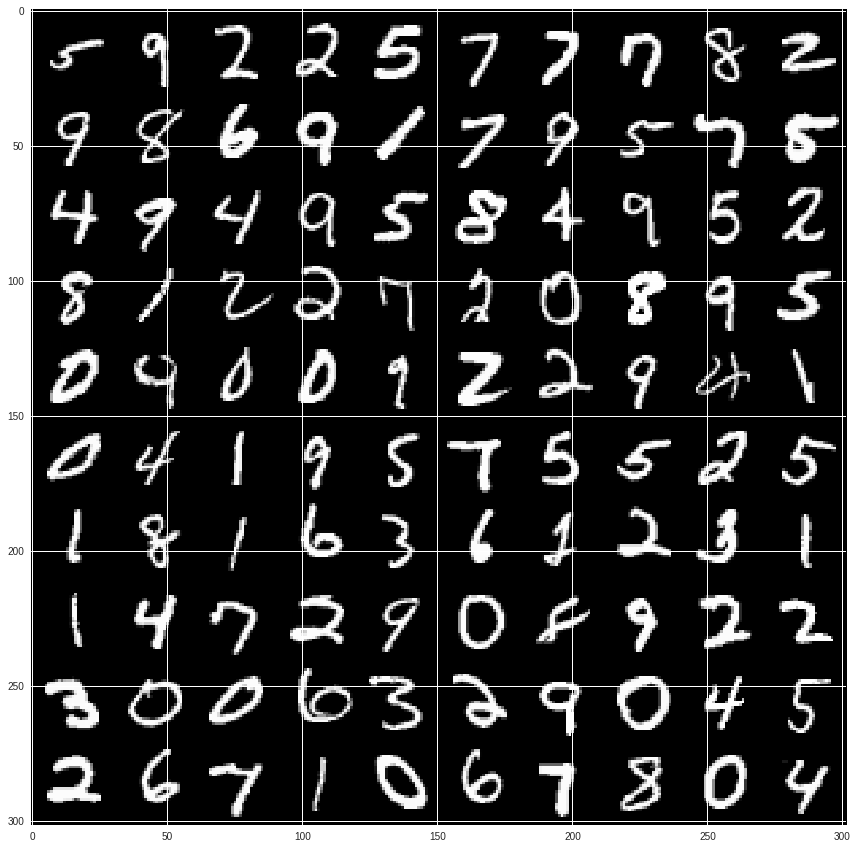

In [166]:
# visualization of a batch of images
batch = next(iter(train_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize = (15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("labels", labels)


In [0]:
# creating the convolutional network
class Classifier(nn.Module):
    """Convnet Classifier"""        
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Conv layer 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Conv layer 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Conv layer 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Conv layer 4
            nn.Conv2d(in_channels=128, out_channels=512, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
            
        )
        # Logistic Regression
        self.clf = nn.Linear(512, 10)    
    
    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


In [169]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


We use the mini-batch gradient descent as an optimization algorithm and an exponential learning rate decay after each epoch (as long as we keep a higher learning rate than *min_lr*).

In [0]:
cnn = Classifier()
if cuda_available:
    cnn = cnn.cuda()
learning_decay = 0.9
min_lr = 0.001
init_lr = 0.1
optimizer = torch.optim.SGD(cnn.parameters(), lr=init_lr)
criterion = nn.CrossEntropyLoss()

We can verify the number of the parameters:

In [171]:
sum(p.numel() for p in cnn.parameters())

688138

We then define two functions *train* and *live_plot* that allow us to perform the training of the network and to plot the accuracy and error live (after each epoch).

In [0]:
def live_plot(data_dict1, title1, data_dict2, title2, figsize=(7,5), bestEpoch=0):
    #clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1)
    for label,data in data_dict1.items():
        plt.plot(data, label=label)
        if label == 'validation accuracy':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title1)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.subplot(1,2,2)
    for label,data in data_dict2.items():
        plt.plot(data, label=label)
        if label == 'validation loss':
            plt.plot(bestEpoch, data[bestEpoch], "ro")
    plt.title(title2)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show();

def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10, init_lr = init_lr):
    dataplot1 = dict([(key, []) for key in ['train accuracy', 'validation accuracy']])
    dataplot2 = dict([(key, []) for key in ['train loss', "validation loss"]])
    best_valid_loss= float("inf")
    for epoch in range(n_epochs):
        loss_train,loss_valid = [],[]
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
            if batch_idx%100==0:
                print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
        
        model.eval()
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_train.append(loss.data.item())
        dataplot2["train loss"].append(np.mean(loss_train))
        
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss_valid.append(loss.data.item())
        dataplot2["validation loss"].append(np.mean(loss_valid))
        if best_valid_loss > dataplot2["validation loss"][-1]:
            best_valid_loss = dataplot2["validation loss"][-1]
            best_Epoch = epoch
            best_model = copy.deepcopy(model)
            
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).sum()
        dataplot1["train accuracy"].append((100.*correct.item()/total))
        
        total = 0
        correct = 0
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            if cuda_available:
                inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).sum()
            
        dataplot1["validation accuracy"].append((100.*correct.item()/total))
        print('Epoch : %d ; Learning rate : %lr ; Validation Acc : %.3f' % (epoch, init_lr, 100.*correct.item()/total))
        print('--------------------------------------------------------------')
        
        live_plot(dataplot1,"Accuracy", dataplot2, "Loss", (14,5), best_Epoch)
            
        model.train()
        if init_lr*learning_decay>min_lr:
            init_lr *= learning_decay
            optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
             
    return dataplot1, dataplot2, best_Epoch, best_model

**Traning the convolutional network on MNIST for 10 epochs:**
___

Epoch : 0 Loss : 2.308 
Epoch : 0 Loss : 2.112 
Epoch : 0 Loss : 1.442 
Epoch : 0 Loss : 1.057 
Epoch : 0 Loss : 0.840 
Epoch : 0 ; Learning rate : 0.1 ; Validation Acc : 96.250
--------------------------------------------------------------


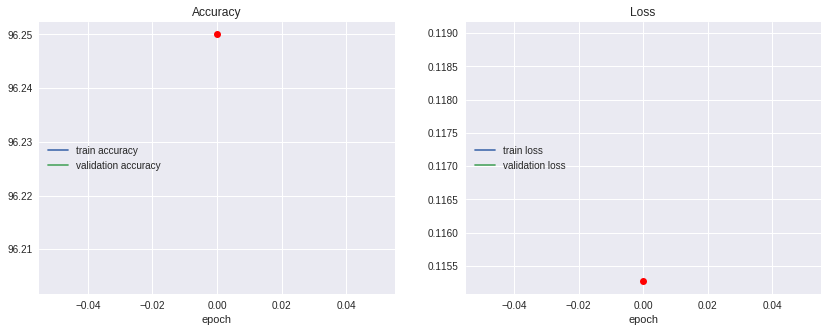

Epoch : 1 Loss : 0.088 
Epoch : 1 Loss : 0.105 
Epoch : 1 Loss : 0.098 
Epoch : 1 Loss : 0.098 
Epoch : 1 Loss : 0.095 
Epoch : 1 ; Learning rate : 0.09000000000000001 ; Validation Acc : 97.940
--------------------------------------------------------------


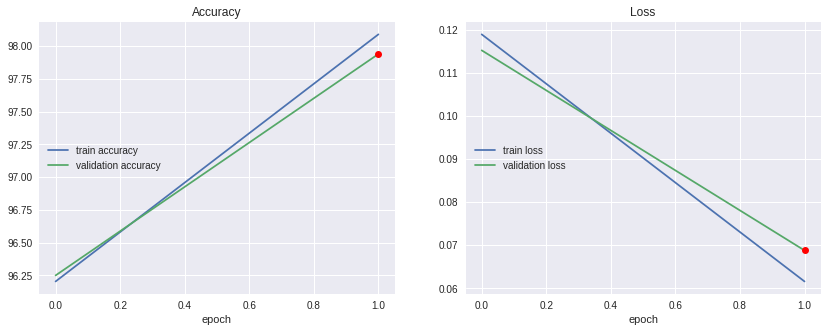

Epoch : 2 Loss : 0.073 
Epoch : 2 Loss : 0.062 
Epoch : 2 Loss : 0.062 
Epoch : 2 Loss : 0.062 
Epoch : 2 Loss : 0.062 
Epoch : 2 ; Learning rate : 0.08100000000000002 ; Validation Acc : 98.400
--------------------------------------------------------------


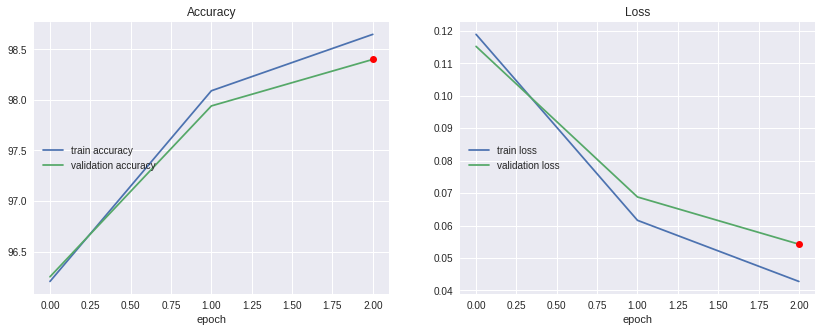

Epoch : 3 Loss : 0.039 
Epoch : 3 Loss : 0.041 
Epoch : 3 Loss : 0.046 
Epoch : 3 Loss : 0.042 
Epoch : 3 Loss : 0.042 
Epoch : 3 ; Learning rate : 0.07290000000000002 ; Validation Acc : 98.440
--------------------------------------------------------------


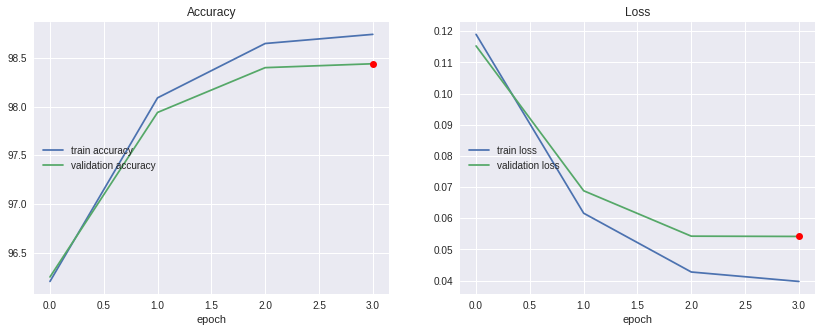

Epoch : 4 Loss : 0.048 
Epoch : 4 Loss : 0.035 
Epoch : 4 Loss : 0.037 
Epoch : 4 Loss : 0.035 
Epoch : 4 Loss : 0.034 
Epoch : 4 ; Learning rate : 0.06561000000000002 ; Validation Acc : 98.580
--------------------------------------------------------------


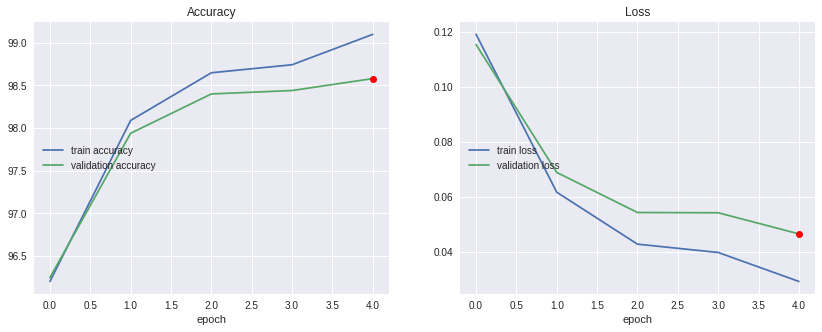

Epoch : 5 Loss : 0.107 
Epoch : 5 Loss : 0.030 
Epoch : 5 Loss : 0.029 
Epoch : 5 Loss : 0.028 
Epoch : 5 Loss : 0.027 
Epoch : 5 ; Learning rate : 0.05904900000000002 ; Validation Acc : 98.940
--------------------------------------------------------------


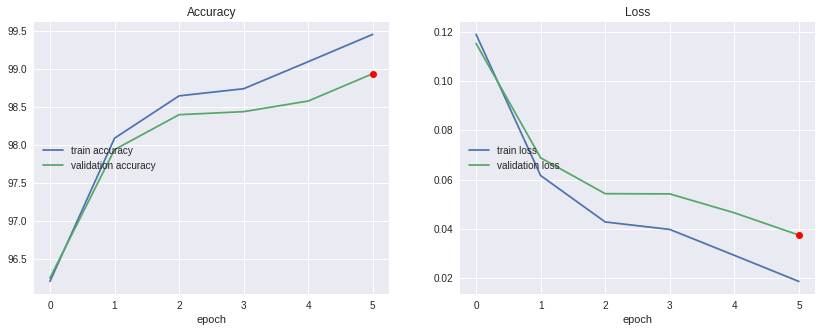

Epoch : 6 Loss : 0.002 
Epoch : 6 Loss : 0.024 
Epoch : 6 Loss : 0.022 
Epoch : 6 Loss : 0.023 
Epoch : 6 Loss : 0.022 
Epoch : 6 ; Learning rate : 0.05314410000000002 ; Validation Acc : 98.800
--------------------------------------------------------------


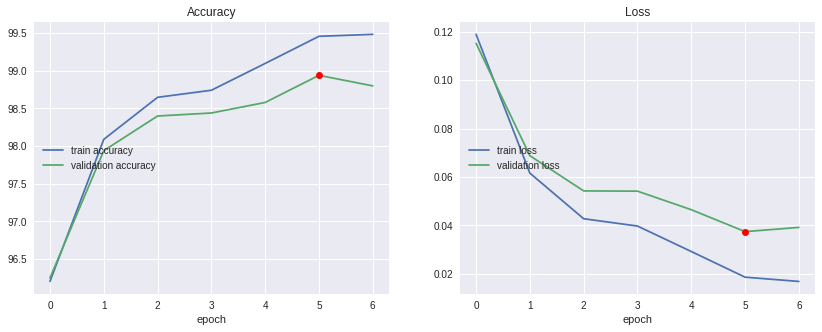

Epoch : 7 Loss : 0.006 
Epoch : 7 Loss : 0.021 
Epoch : 7 Loss : 0.018 
Epoch : 7 Loss : 0.019 
Epoch : 7 Loss : 0.018 
Epoch : 7 ; Learning rate : 0.04782969000000002 ; Validation Acc : 98.880
--------------------------------------------------------------


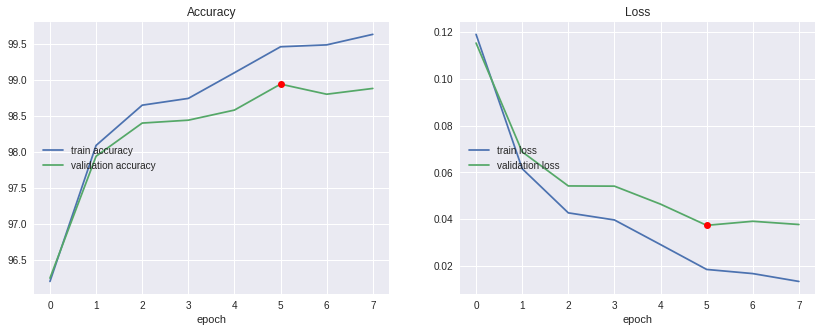

Epoch : 8 Loss : 0.004 
Epoch : 8 Loss : 0.017 
Epoch : 8 Loss : 0.015 
Epoch : 8 Loss : 0.015 
Epoch : 8 Loss : 0.016 
Epoch : 8 ; Learning rate : 0.043046721000000024 ; Validation Acc : 98.920
--------------------------------------------------------------


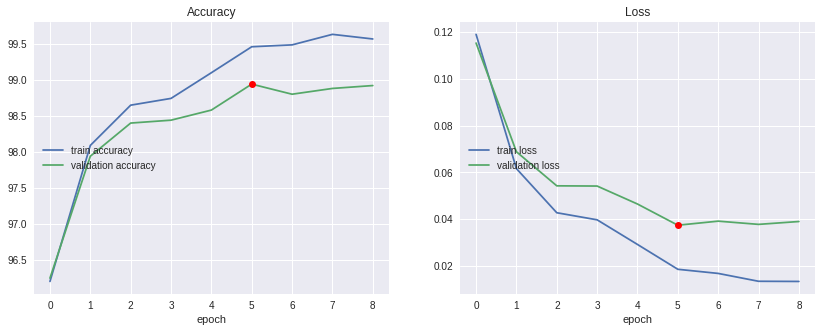

Epoch : 9 Loss : 0.005 
Epoch : 9 Loss : 0.012 
Epoch : 9 Loss : 0.013 
Epoch : 9 Loss : 0.013 
Epoch : 9 Loss : 0.013 
Epoch : 9 ; Learning rate : 0.03874204890000002 ; Validation Acc : 98.920
--------------------------------------------------------------


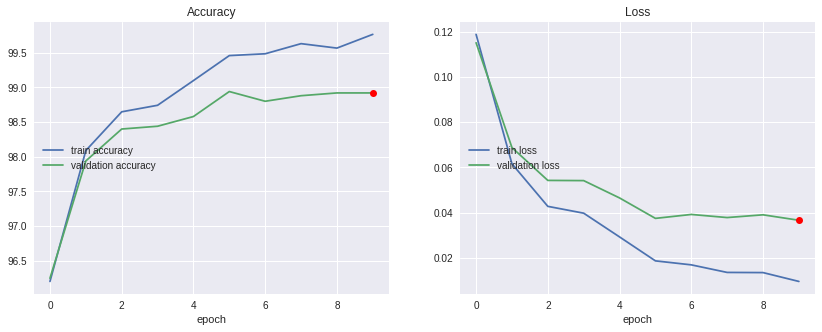

In [173]:
Accuracies, Losses, best_Epoch, best_model = train(cnn, train_loader,valid_loader, criterion, optimizer, 10)

In [174]:
total = 0
correct = 0
for batch_idx, (inputs, targets) in enumerate(test_loader):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    outputs = best_model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).sum()
print("Test Accuracy = ",100.*correct.item()/total)

Test Accuracy =  99.14


We obtain a test accuracy of 99.14 %, which is a quite high accuracy.

### 2. Compare the performances of CNN vs MLP. Comment.<a id='2.2'></a>
___

After performing random search for the multi-layer perceptron, we obtain a model with 98.41% test accuracy. From the other side and without hyperparameter search, the convolutional neural network gave a test accuracy of 99.14%. It is clear that the CNN outperform the MLP on this task of image classification.  


Here is the performance of the CNN during 10 epochs:

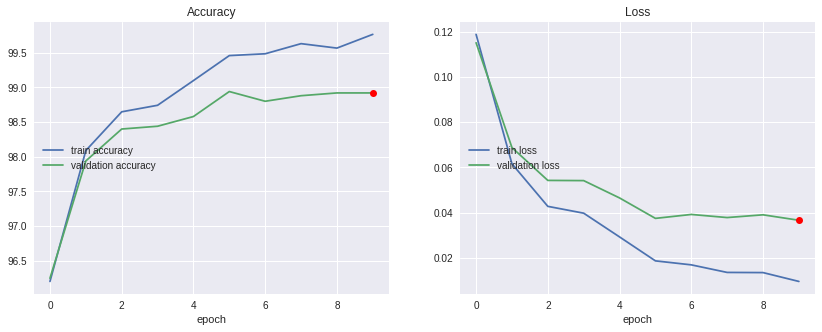

Here is the performance of the MLP during 10 epochs:

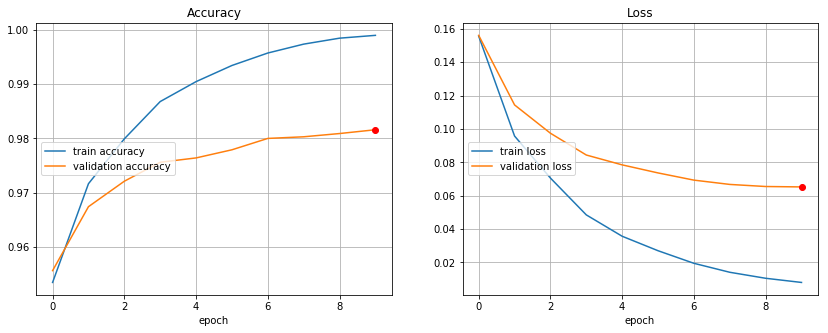


We notice that the convergence of the MLP loss and accuracy are smoother than the CNN's. This might be due to the learning rate that we used in the convolutional network: when the learning rate is not small enough, we might get a higher loss even while moving in the opposite direction of the gradient because the step is not small enough. Another remark is that the CNN starts with a higher accuracy and the difference between the train and validation performance is smaller (might be indicator of a better overall performance because the overfitting risk is lower).


One caveat must be added, the MNIST dataset has only one channel (only the grey color) and 10 output classes, which makes the classification task easier compared to other datasets. The performance of the MLP should then be placed in this context. However, for more complicated image classification tasks, it is known that convolutional networks outperform MLPs.


In fact, even if both models have high performance on the test set, we know that convolutional neural networks are more adapted to image data because they leverage 3 main ideas:

- Local connectivity: connecting each hidden unit to a subregion of the input image as well as making it connected to all channels. This makes that we reduce very much the number of parameters. This is clear if we compare the two networks: they both have approximately the same number of parameters. However, the CNN has 9 layers (4 convolutional layers, 4 pooling layers and one fully connected layer) whereas the MLP has only 2 hidden layers. Furthermore, we avoid the expensive cost of the calculating the preactivations in our convolutional network compared to our multi-layer perceptron (reducing the number of multiplications between weights and units).
- Parameter sharing: the parameters are shared between units within the same feature maps and are connected to different parts of the image. Again, this helps with reducing drastically the number of parameters compared to the multi-layer perceptron. In addition to that, this makes that the features are equivariant (extracting the same features from at every position).
- Pooling: we used 4 layers for max pooling that consists of taking the highest value within a subsample (non-overlapping in general). This makes that we have less hidden units in our hidden layers. But it also introduces some local invariance regarding translation, which is a way of encoding our prior knowledge about images (they are generally not sensitive to local translation). This prior knowledge is not encoded in the MLP, which might explain why the test accuracy is 99.14% for the CNN while it is 98.41%.

For these main reasons, convolutional neural networks are more adapted for tasks using image data and more generally data that has similar spacial characteristics (local invariance regarding translation ...etc).  